# Common code

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import numpy as np
from tqdm.notebook import trange, tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from sklearn.metrics import accuracy_score

import time

from idlmam import weight_reset, moveTo

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

loss_func = nn.CrossEntropyLoss()

score_funcs={'Accuracy': accuracy_score}

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None, disable_tqdm=False):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs.
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary.
    desc -- a description to use for the progress bar.
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False, disable=disable_tqdm):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

# Excercise 1
Modify the `train_network` function to accept `lr_schedule=ReduceLROnPlateau` as a valid argument. If the `train_network` function gets this string argument, it should check whether validation and test sets have been provided and, if so, set up the `ReduceLROnPlateau` scheduler appropriately.

In [15]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None,
                         lr = 0.0001, lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use.
    optimizer -- the method used to alter the gradients for learning.

    """
    if score_funcs == None:
        score_funcs = {}#Empty set

    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

    if lr_schedule is not None and val_loader is not None and lr_schedule == 'ReduceLROnPlateau':
        lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training", disable_tqdm=disable_tqdm)

        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )

        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating", disable_tqdm=disable_tqdm)

            if lr_schedule is not None:
                if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    lr_schedule.step(results["val loss"][-1])
                else:
                    lr_schedule.step()

        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing", disable_tqdm=disable_tqdm)

        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

# Excercise 2
Rerun the experiments with `AdamW`, SGD with Nesterov momentum, and the cosine annealing schedule using batch sizes of B = 1, 4, 32, 64, 128. How does the change in batch size impact the effectiveness and accuracy of these three tools?

In [16]:
train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 128
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n, classes),
)

In [ ]:
eta_0 = 0.001
epochs = 8

results_adam = {}

for B in [1, 4, 32, 64, 128]:
    train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=B)
    start = time.time()
    optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_0)

    e2_results_adam = train_network(fc_model, loss_func, train_loader, test_loader=test_loader,
                                    optimizer=optimizer, epochs=epochs, lr=eta_0, score_funcs=score_funcs, device=device)
    duration = time.time() - start
    results_adam[B] = e2_results_adam
    sns.lineplot(x='epoch', y='test Accuracy', data=e2_results_adam, label=f'Adam, B={B}')
    print(f"Completed for B={B} in {duration}")
    fc_model.apply(weight_reset)

In [ ]:
results_sdg_nesterov = {}

for B in [1, 4, 32, 64, 128]:
    train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=B)
    start = time.time()
    optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0, momentum=0.9, nesterov=True)
    e2_results_nesterov = train_network(fc_model, loss_func, train_loader,
                                        test_loader=test_loader, epochs=epochs,
                                        optimizer=optimizer, lr=eta_0,
                                        score_funcs=score_funcs, device=device)
    duration = time.time() - start
    results_sdg_nesterov[B] = e2_results_nesterov
    sns.lineplot(x='epoch', y='test Accuracy', data=e2_results_nesterov, label=f'SDG Nesterov, B={B}')
    print(f"Completed for B={B} in {duration}")
    fc_model.apply(weight_reset)

In [ ]:
results_cosine = {}

for B in [1, 4, 32, 64, 128]:
    train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=B)
    start = time.time()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.0001)
    e2_results_cosine = train_network(fc_model, loss_func, train_loader,
                                        test_loader=test_loader, epochs=epochs,
                                        lr_schedule=scheduler, lr=eta_0,
                                        score_funcs=score_funcs, device=device)
    duration = time.time() - start
    results_cosine[B] = e2_results_cosine
    sns.lineplot(x='epoch', y='test Accuracy', data=e2_results_cosine, label=f'Cosine, B={B}')
    print(f"Completed for B={B} in {duration}")
    fc_model.apply(weight_reset)

Conclusion:
AdamW works better with larger batches even after 1 epoch
Surprisingly, for SDG + Nesterov and low number of epochs (I used only 8 epochs), the best performance after 1 epoch and after 8 epochs is observed for smaller batch size values (B=1 and B=4)
The cosine annealing schedule + a "regular SGD" shows better results per epoch for smaller batches.

# Excercise 3
Write code that creates a neural network with n = 256 neurons and an argument to control how many hidden layers are in the network. Then train networks with 1, 6, 12, and 24 hidden layers using naive SGD and again using `AdamW` with cosine annealing. How do these new optimizers impact your ability to learn these deeper networks?

In [ ]:
n=256

def custom_depth_fc_model(n_hidden_layers, inputs, classes):
    sequential_layers = [
    nn.Flatten(), nn.Linear(inputs, n), nn.Tanh(),
    ]

    for _ in range(n_hidden_layers-1):
        sequential_layers.append( nn.Linear(n, n) )
        sequential_layers.append( nn.Tanh() )

    sequential_layers.append(nn.Linear(n, classes))
    return nn.Sequential(*sequential_layers)

In [ ]:
B=256
epochs = 60

train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

results_sdg = {}

for n_layers in [1, 6, 12, 24]:
    fc_model = custom_depth_fc_model(n_layers, D, classes)

    start = time.time()

    fc_result = train_network(fc_model, loss_func, train_loader,
                                        test_loader=test_loader, epochs=epochs,
                                        checkpoint_file="e3_sgd.dat",
                                        lr=eta_0, score_funcs=score_funcs, device=device)
    duration = time.time() - start
    results_sdg[n_layers] = fc_result
    sns.lineplot(x='epoch', y='test Accuracy', data=fc_result, label=f'SGD, L={n_layers}')
    print(f"Completed for L={n_layers} in {duration}")

In [ ]:
results_adamw_cosine = {}

train_sub_set, val_sub_set = torch.utils.data.random_split(train_data, [int(len(train_data)*0.8), int(len(train_data)*0.2)])

train_sub_loader = DataLoader(train_sub_set, batch_size=B, shuffle=True)
val_sub_loader = DataLoader(val_sub_set, batch_size=B)

for n_layers in [1, 6, 12, 24]:
    fc_model = custom_depth_fc_model(n_layers, D, classes)

    start = time.time()

    optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.0001)

    fc_result = train_network(fc_model, loss_func, train_sub_loader,
                                        test_loader=test_loader,
                                        val_loader=val_sub_loader,
                                        epochs=epochs,
                                        checkpoint_file="e3_adamw.dat",
                                        lr_schedule=scheduler, optimizer=optimizer,
                                        lr=eta_0, score_funcs=score_funcs, device=device)
    duration = time.time() - start
    results_adamw_cosine[n_layers] = fc_result
    sns.lineplot(x='epoch', y='test Accuracy', data=fc_result, label=f'AdamW+Cosine, L={n_layers}')
    print(f"Completed for L={n_layers} in {duration}")

Conclusion: 24-layer network did not start converging even after 30 epochs for both approaches.
For smaller networks, AdamW + Cosine annealing demonstrates higher performance than "simple SGD".
The biggest difference can be observed for 12-layers netwrk. With SGD it just starts converging a bit after 30 epochs. With AdamW it learned well even after 1 epoch.

# Excercise 4
Retrain the three-layer bidirectional RNN from the last chapter with each of the new optimizers from this chapter. How do they impact the results?

In [ ]:
from idlmam import EmbeddingPackable, LastTimeStep, pad_and_pack, LanguageNameDataset, train_network

zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io

r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

name_language_data_utf = {}

for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            language_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            name_language_data_utf[lang] = language_names

def dictToVocabulary(lang_name_dict):
    found_chars = set()
    for lang_names in lang_name_dict.values():
        for name in lang_names:
            for char in name:
                found_chars.add(char)
    vocabulary = {}
    for i, ch in enumerate(found_chars):
        vocabulary[ch] = i
    return vocabulary

dataset = LanguageNameDataset(name_language_data_utf, dictToVocabulary(name_language_data_utf))

D = 64
hidden_nodes = 256
vocab_size = len(dataset.vocabulary)
rnn_classes = len(dataset.label_names)
B = 8
rnn_epochs=30
eta_0 = 0.00001

rnn_3layer_bidir_model = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
    LastTimeStep(rnn_layers=3, bidirectional=True),
    nn.Linear(hidden_nodes*2, rnn_classes),
)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset) - 300, 300))
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

rnn_result_sgd = train_network(rnn_3layer_bidir_model, loss_func, train_loader,
                                test_loader=test_loader,
                                score_funcs=score_funcs,
                                device=device, epochs=rnn_epochs)

rnn_3layer_bidir_model.apply(weight_reset)

optimizer = torch.optim.AdamW(rnn_3layer_bidir_model.parameters(), lr=eta_0)

rnn_result_adam = train_network(rnn_3layer_bidir_model, loss_func, train_loader,
                                test_loader=test_loader,
                                optimizer=optimizer,
                                score_funcs=score_funcs,
                                device=device, epochs=rnn_epochs)

rnn_3layer_bidir_model.apply(weight_reset)

In [ ]:
train_subset_length = int(len(train_data)*0.8)
train_sub_set, val_sub_set = torch.utils.data.random_split(train_data, [train_subset_length, len(train_data) - train_subset_length])

train_sub_loader = DataLoader(train_sub_set, batch_size=B, collate_fn=pad_and_pack, shuffle=True)
val_sub_loader = DataLoader(val_sub_set, collate_fn=pad_and_pack, batch_size=B)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, rnn_epochs//3, eta_min=0.000001)

rnn_result_adam_cosine = train_network(rnn_3layer_bidir_model, loss_func, train_sub_loader,
                                       test_loader=test_loader,
                                       val_loader=val_sub_loader,
                                       optimizer=optimizer, lr_schedule=scheduler,
                                       score_funcs=score_funcs,
                                       device=device, epochs=rnn_epochs)

rnn_3layer_bidir_model.apply(weight_reset)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

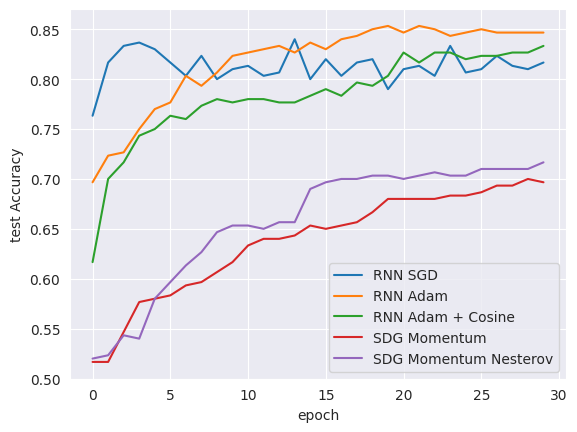

In [16]:
rnn_3layer_bidir_model.apply(weight_reset)

optimizer_momentum = torch.optim.SGD(rnn_3layer_bidir_model.parameters(), lr=eta_0, momentum=0.9, nesterov=False)

rnn_result_sdg_momentum = train_network(rnn_3layer_bidir_model, loss_func, train_loader,
                                test_loader=test_loader,
                                optimizer=optimizer_momentum,
                                score_funcs=score_funcs,
                                device=device, epochs=rnn_epochs)

optimizer_momentum_nesterov = torch.optim.SGD(rnn_3layer_bidir_model.parameters(), lr=eta_0, momentum=0.9, nesterov=True)

rnn_3layer_bidir_model.apply(weight_reset)

rnn_result_sdg_momentum_nesterov = train_network(rnn_3layer_bidir_model, loss_func, train_loader,
                                test_loader=test_loader,
                                optimizer=optimizer_momentum_nesterov,
                                score_funcs=score_funcs,
                                device=device, epochs=rnn_epochs)

sns.lineplot(x='epoch', y='test Accuracy', data=rnn_result_sgd, label='RNN SGD')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_result_adam, label='RNN Adam')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_result_adam_cosine, label='RNN Adam + Cosine')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_result_sdg_momentum, label='SDG Momentum')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_result_sdg_momentum_nesterov, label='SDG Momentum Nesterov')

Conclusion: AdamW and AdamW + Cosine Annealing boost up bidirectional RNN training.

# Excercise 5
Add gradient clipping to the experiments from exercise 4. Does it help or hurt the RNN?

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/1978 [00:00<?, ?it/s]

Validating:   0%|          | 0/495 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

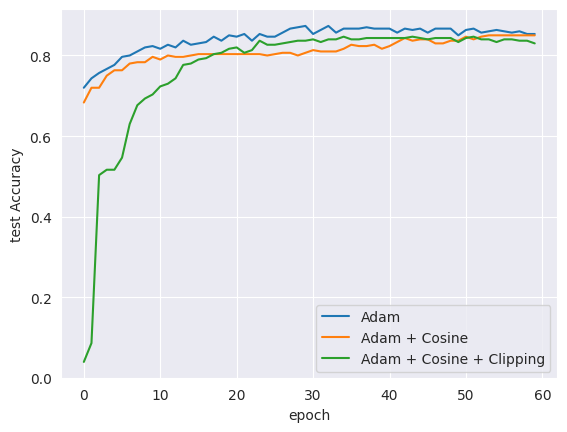

In [19]:
rnn_epochs=60

rnn_3layer_bidir_model = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True),
    LastTimeStep(rnn_layers=3, bidirectional=True),
    nn.Linear(hidden_nodes*2, rnn_classes),
)

optimizer = torch.optim.AdamW(rnn_3layer_bidir_model.parameters(), lr=eta_0)

rnn_result_adam = train_network(rnn_3layer_bidir_model, loss_func, train_loader,
                                test_loader=test_loader,
                                optimizer=optimizer,
                                score_funcs=score_funcs,
                                device=device, epochs=rnn_epochs)

rnn_3layer_bidir_model.apply(weight_reset)

train_subset_length = int(len(train_data)*0.8)
train_sub_set, val_sub_set = torch.utils.data.random_split(train_data, [train_subset_length, len(train_data) - train_subset_length])

train_sub_loader = DataLoader(train_sub_set, batch_size=B, collate_fn=pad_and_pack, shuffle=True)
val_sub_loader = DataLoader(val_sub_set, collate_fn=pad_and_pack, batch_size=B)

optimizer = torch.optim.AdamW(rnn_3layer_bidir_model.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, rnn_epochs//3)

rnn_result_adam_cosine = train_network(rnn_3layer_bidir_model, loss_func, train_sub_loader,
                                       test_loader=test_loader,
                                       val_loader=val_sub_loader,
                                       optimizer=optimizer, lr_schedule=scheduler,
                                       score_funcs=score_funcs,
                                       device=device, epochs=rnn_epochs)

rnn_3layer_bidir_model.apply(weight_reset)

for p in rnn_3layer_bidir_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

rnn_result_adam_cosine_clipping = train_network(rnn_3layer_bidir_model, loss_func, train_sub_loader,
                                       test_loader=test_loader,
                                       val_loader=val_sub_loader,
                                       optimizer=optimizer, lr_schedule=scheduler,
                                       score_funcs=score_funcs,
                                       device=device, epochs=rnn_epochs)

rnn_3layer_bidir_model.apply(weight_reset)

sns.lineplot(x='epoch', y='test Accuracy', data=rnn_result_adam, label='Adam')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_result_adam_cosine, label='Adam + Cosine')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_result_adam_cosine_clipping, label='Adam + Cosine + Clipping')

Conclusion: Looks like gradient clipping does not add any benefits to RNN learning, while AdamW + Cosine look promising after 60 epochs of training.
However, "pure AdamW" shows slightly better performance.

# Excercise 6
Write your own function that uses Optuna to optimize the parameters of a fully connected neural network. Once it’s done, create a new network with those hyperparameters, train it using all of the training data, and test it on the held-out test set. What results do you get on FashionMNIST, and how close is Optuna’s guess at the accuracy compared to your test-set performance?

In [18]:
import optuna

epochs=30
B=128

train_subset_length = int(len(train_data)*0.8)
train_sub_set, test_sub_set = torch.utils.data.random_split(train_data, [train_subset_length, len(train_data) - train_subset_length])

train_sub_loader = DataLoader(train_sub_set, batch_size=B, shuffle=True)
test_sub_loader = DataLoader(test_sub_set, batch_size=B)

def define_model(trial):
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 7)
    hidden_neurons = trial.suggest_int("hidden_neurons", 8, 256)
    layers = [nn.Flatten(), nn.Linear(D, hidden_neurons)]

    for i in range(n_hidden_layers):
        layers.append(nn.Linear(hidden_neurons, hidden_neurons))
        layers.append(nn.Tanh())

    layers.append(nn.Linear(hidden_neurons, classes))
    return nn.Sequential(*layers)

def objective(trial):
    model = define_model(trial)

    optimizer = torch.optim.AdamW(model.parameters(), lr=trial.suggest_float('learning_rate', 1e-5, 1e-2))

    for epoch in range(epochs):
        results = train_network(model, loss_func, train_sub_loader,
                               test_loader=test_sub_loader,
                               optimizer=optimizer,
                               score_funcs=score_funcs,
                               device=device, epochs=1,
                               disable_tqdm=True)

        cur_accuracy = results['test Accuracy'].iloc[-1]

        trial.report(cur_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return cur_accuracy

study_e6 = optuna.create_study(direction='maximize')
study_e6.optimize(objective, n_trials=20)

[I 2023-03-11 17:33:30,563] A new study created in memory with name: no-name-c104f67a-0e34-47f1-8c0c-92a630594e3d
[I 2023-03-11 17:36:58,448] Trial 0 finished with value: 0.8770833333333333 and parameters: {'n_hidden_layers': 3, 'hidden_neurons': 86, 'learning_rate': 0.0020730165104942346}. Best is trial 0 with value: 0.8770833333333333.
[I 2023-03-11 17:40:26,323] Trial 1 finished with value: 0.8678333333333333 and parameters: {'n_hidden_layers': 2, 'hidden_neurons': 132, 'learning_rate': 0.003153912179410546}. Best is trial 0 with value: 0.8770833333333333.
[I 2023-03-11 17:44:08,545] Trial 2 finished with value: 0.8745 and parameters: {'n_hidden_layers': 7, 'hidden_neurons': 130, 'learning_rate': 0.0011216231468772111}. Best is trial 0 with value: 0.8770833333333333.
[I 2023-03-11 17:47:29,528] Trial 3 finished with value: 0.8588333333333333 and parameters: {'n_hidden_layers': 2, 'hidden_neurons': 137, 'learning_rate': 0.003992925849538943}. Best is trial 0 with value: 0.87708333333

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

0.877


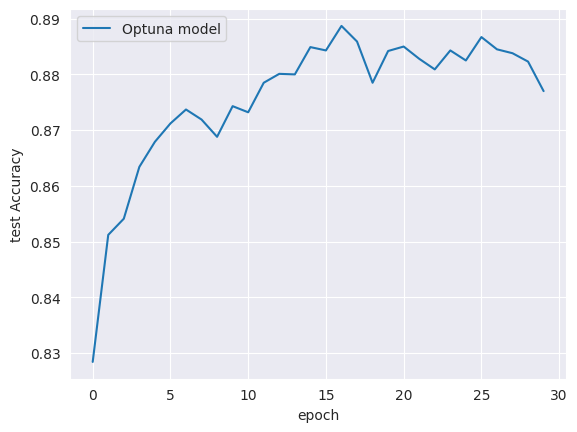

In [22]:
n_hidden_layers = study_e6.best_params['n_hidden_layers']
hidden_neurons = study_e6.best_params['hidden_neurons']
layers = [nn.Flatten(), nn.Linear(D, hidden_neurons)]

for i in range(n_hidden_layers):
    layers.append(nn.Linear(hidden_neurons, hidden_neurons))
    layers.append(nn.Tanh())

layers.append(nn.Linear(hidden_neurons, classes))
fc_model_e6 = nn.Sequential(*layers)

optimizer = torch.optim.AdamW(fc_model_e6.parameters(), lr=study_e6.best_params['learning_rate'])

train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

results_e6 = train_network(fc_model_e6, loss_func, train_loader,
                       test_loader=test_loader,
                       optimizer=optimizer,
                       score_funcs=score_funcs,
                       device=device, epochs=epochs)

sns.lineplot(x='epoch', y='test Accuracy', data=results_e6, label='Optuna model')
print(results_e6['test Accuracy'].iloc[-1])

Conclusion: Resulting performance of a copy of model suggested by Optuna is a bit worse than during Optuna study.
This is caused by "less lucky" initial (and random) model state.

# Excercise 7
Redo exercise 6, but replace the hidden layers with convolutional ones and add a new argument that controls how many rounds of max pooling to perform. How does it perform on FashionMNIST compared with your results from exercise 6?

In [41]:
epochs=20

def define_model_cnn(trial):
    K = 3
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 7)
    filters = trial.suggest_int("filters", 10, 32)
    max_pooling_layers = trial.suggest_int("max_pooling_layers", 0, min((n_conv_layers - 1) // 2, 3))
    layers = [nn.Conv2d(C, filters, K, padding=K//2), nn.Tanh()]
    if max_pooling_layers != 0:
        max_pool_every_n_layers = n_conv_layers // max_pooling_layers
    else:
        max_pool_every_n_layers = 0
    print(f"max_pool_every_n_layers={max_pool_every_n_layers}")

    for i in range(n_conv_layers):
        layers.append(nn.Conv2d(filters, filters, K, padding=K//2))
        layers.append(nn.Tanh())
        if max_pool_every_n_layers != 0 and (i + 1) % max_pool_every_n_layers == 0:
            print(f"cnn layers: {n_conv_layers}, maxpool layers: {max_pooling_layers}, on layer {i}")
            layers.append(nn.MaxPool2d(2))

    layers.append(nn.Flatten())
    linear_inputs = filters * D
    if max_pooling_layers != 0:
        linear_inputs = linear_inputs // (4 ** max_pooling_layers)
    print(f"inputs: {linear_inputs}, max_pooling_layers={max_pooling_layers}")
    layers.append(nn.Linear(linear_inputs, classes))
    return nn.Sequential(*layers)

def objective_cnn(trial):
    model = define_model_cnn(trial)

    optimizer = torch.optim.AdamW(model.parameters(), lr=trial.suggest_float('learning_rate', 1e-5, 1e-2))

    for epoch in range(epochs):
        results = train_network(model, loss_func, train_sub_loader,
                               test_loader=test_sub_loader,
                               optimizer=optimizer,
                               score_funcs=score_funcs,
                               device=device, epochs=1,
                               disable_tqdm=True)

        cur_accuracy = results['test Accuracy'].iloc[-1]

        trial.report(cur_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return cur_accuracy

study_e6 = optuna.create_study(direction='maximize')
study_e6.optimize(objective_cnn, n_trials=20)

[I 2023-03-11 22:22:31,888] A new study created in memory with name: no-name-60cb9fa3-7c1c-4c14-b112-60cae56b964d


max_pool_every_n_layers=7
cnn layers: 7, maxpool layers: 1, on layer 6
inputs: 4312, max_pooling_layers=1


[I 2023-03-11 22:30:42,824] Trial 0 finished with value: 0.807 and parameters: {'n_conv_layers': 7, 'filters': 22, 'max_pooling_layers': 1, 'learning_rate': 0.008071561593689356}. Best is trial 0 with value: 0.807.


max_pool_every_n_layers=4
cnn layers: 4, maxpool layers: 1, on layer 3
inputs: 5488, max_pooling_layers=1


[I 2023-03-11 22:39:26,390] Trial 1 finished with value: 0.8658333333333333 and parameters: {'n_conv_layers': 4, 'filters': 28, 'max_pooling_layers': 1, 'learning_rate': 0.008670880586777181}. Best is trial 1 with value: 0.8658333333333333.


max_pool_every_n_layers=7
cnn layers: 7, maxpool layers: 1, on layer 6
inputs: 5684, max_pooling_layers=1


[I 2023-03-11 22:51:35,781] Trial 2 finished with value: 0.8896666666666667 and parameters: {'n_conv_layers': 7, 'filters': 29, 'max_pooling_layers': 1, 'learning_rate': 0.0023415536707094976}. Best is trial 2 with value: 0.8896666666666667.


max_pool_every_n_layers=0
inputs: 10192, max_pooling_layers=0


[I 2023-03-11 22:55:04,399] Trial 3 finished with value: 0.864 and parameters: {'n_conv_layers': 2, 'filters': 13, 'max_pooling_layers': 0, 'learning_rate': 0.004318394666452324}. Best is trial 2 with value: 0.8896666666666667.


max_pool_every_n_layers=5
cnn layers: 5, maxpool layers: 1, on layer 4
inputs: 5292, max_pooling_layers=1


[I 2023-03-11 23:01:24,136] Trial 4 finished with value: 0.83125 and parameters: {'n_conv_layers': 5, 'filters': 27, 'max_pooling_layers': 1, 'learning_rate': 0.008204239290732508}. Best is trial 2 with value: 0.8896666666666667.


max_pool_every_n_layers=0
inputs: 10976, max_pooling_layers=0


[I 2023-03-11 23:06:25,015] Trial 5 finished with value: 0.81625 and parameters: {'n_conv_layers': 5, 'filters': 14, 'max_pooling_layers': 0, 'learning_rate': 0.009044858388796971}. Best is trial 2 with value: 0.8896666666666667.


max_pool_every_n_layers=3
cnn layers: 6, maxpool layers: 2, on layer 2
cnn layers: 6, maxpool layers: 2, on layer 5
inputs: 1078, max_pooling_layers=2


[I 2023-03-11 23:06:41,389] Trial 6 pruned. 


max_pool_every_n_layers=3
cnn layers: 6, maxpool layers: 2, on layer 2
cnn layers: 6, maxpool layers: 2, on layer 5
inputs: 1568, max_pooling_layers=2


[I 2023-03-11 23:13:06,024] Trial 7 finished with value: 0.8956666666666667 and parameters: {'n_conv_layers': 6, 'filters': 32, 'max_pooling_layers': 2, 'learning_rate': 0.0027460449823603164}. Best is trial 7 with value: 0.8956666666666667.


max_pool_every_n_layers=4
cnn layers: 4, maxpool layers: 1, on layer 3
inputs: 5292, max_pooling_layers=1


[I 2023-03-11 23:18:39,267] Trial 8 finished with value: 0.85925 and parameters: {'n_conv_layers': 4, 'filters': 27, 'max_pooling_layers': 1, 'learning_rate': 0.006771668260632726}. Best is trial 7 with value: 0.8956666666666667.


max_pool_every_n_layers=3
cnn layers: 7, maxpool layers: 2, on layer 2
cnn layers: 7, maxpool layers: 2, on layer 5
inputs: 490, max_pooling_layers=2


[I 2023-03-11 23:22:40,680] Trial 9 finished with value: 0.8885 and parameters: {'n_conv_layers': 7, 'filters': 10, 'max_pooling_layers': 2, 'learning_rate': 0.0065848339990264935}. Best is trial 7 with value: 0.8956666666666667.


max_pool_every_n_layers=0
inputs: 25088, max_pooling_layers=0


[I 2023-03-11 23:22:51,478] Trial 10 pruned. 


max_pool_every_n_layers=3
cnn layers: 6, maxpool layers: 2, on layer 2
cnn layers: 6, maxpool layers: 2, on layer 5
inputs: 1568, max_pooling_layers=2


[I 2023-03-11 23:28:58,789] Trial 11 finished with value: 0.9021666666666667 and parameters: {'n_conv_layers': 6, 'filters': 32, 'max_pooling_layers': 2, 'learning_rate': 0.0023777499881127624}. Best is trial 11 with value: 0.9021666666666667.


max_pool_every_n_layers=2
cnn layers: 5, maxpool layers: 2, on layer 1
cnn layers: 5, maxpool layers: 2, on layer 3
inputs: 1568, max_pooling_layers=2


[I 2023-03-11 23:34:03,386] Trial 12 finished with value: 0.9064166666666666 and parameters: {'n_conv_layers': 5, 'filters': 32, 'max_pooling_layers': 2, 'learning_rate': 0.003143069836288611}. Best is trial 12 with value: 0.9064166666666666.


max_pool_every_n_layers=3
cnn layers: 3, maxpool layers: 1, on layer 2
inputs: 3528, max_pooling_layers=1


[I 2023-03-11 23:38:16,198] Trial 13 finished with value: 0.9054166666666666 and parameters: {'n_conv_layers': 3, 'filters': 18, 'max_pooling_layers': 1, 'learning_rate': 0.004050688527675069}. Best is trial 12 with value: 0.9064166666666666.


max_pool_every_n_layers=0
inputs: 14112, max_pooling_layers=0


[I 2023-03-11 23:38:28,538] Trial 14 pruned. 


max_pool_every_n_layers=3
cnn layers: 3, maxpool layers: 1, on layer 2
inputs: 3920, max_pooling_layers=1


[I 2023-03-11 23:42:44,612] Trial 15 finished with value: 0.8498333333333333 and parameters: {'n_conv_layers': 3, 'filters': 20, 'max_pooling_layers': 1, 'learning_rate': 0.005275566688931856}. Best is trial 12 with value: 0.9064166666666666.


max_pool_every_n_layers=0
inputs: 13328, max_pooling_layers=0


[I 2023-03-11 23:42:56,650] Trial 16 pruned. 


max_pool_every_n_layers=0
inputs: 18032, max_pooling_layers=0


[I 2023-03-11 23:43:06,813] Trial 17 pruned. 


max_pool_every_n_layers=4
cnn layers: 4, maxpool layers: 1, on layer 3
inputs: 4900, max_pooling_layers=1


[I 2023-03-11 23:43:23,017] Trial 18 pruned. 


max_pool_every_n_layers=0
inputs: 13328, max_pooling_layers=0


[I 2023-03-11 23:43:33,623] Trial 19 pruned. 


{'n_conv_layers': 5, 'filters': 32, 'max_pooling_layers': 2, 'learning_rate': 0.003143069836288611}


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

0.886


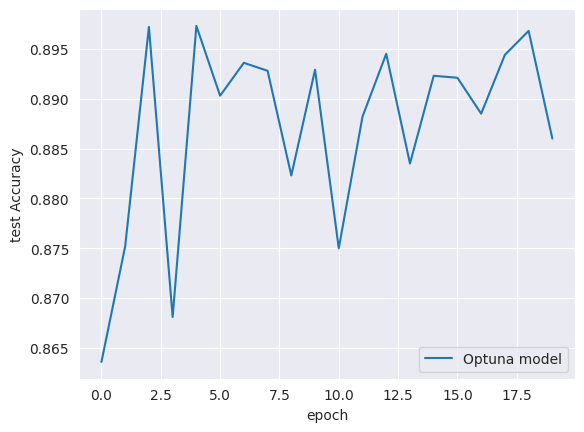

In [43]:
print(study_e6.best_params)

def create_model_from_best_params(best_params):
    K = 3
    n_conv_layers = best_params["n_conv_layers"]
    filters = best_params["filters"]
    max_pooling_layers = best_params["max_pooling_layers"]
    layers = [nn.Conv2d(C, filters, K, padding=K//2), nn.Tanh()]
    if max_pooling_layers != 0:
        max_pool_every_n_layers = n_conv_layers // max_pooling_layers
    else:
        max_pool_every_n_layers = 0

    for i in range(n_conv_layers):
        layers.append(nn.Conv2d(filters, filters, K, padding=K//2))
        layers.append(nn.Tanh())
        if max_pool_every_n_layers != 0 and (i + 1) % max_pool_every_n_layers == 0:
            layers.append(nn.MaxPool2d(2))

    layers.append(nn.Flatten())
    linear_inputs = filters * D
    if max_pooling_layers != 0:
        linear_inputs = linear_inputs // (4 ** max_pooling_layers)
    layers.append(nn.Linear(linear_inputs, classes))
    return nn.Sequential(*layers)

model_from_best_params = create_model_from_best_params(study_e6.best_params)
optimizer = torch.optim.AdamW(model_from_best_params.parameters(), lr=study_e6.best_params['learning_rate'])

results_e7 = train_network(model_from_best_params,
                        loss_func, train_loader,
                        test_loader=test_loader,
                        optimizer=optimizer,
                        score_funcs=score_funcs,
                        device=device, epochs=epochs)

sns.lineplot(x='epoch', y='test Accuracy', data=results_e7, label='Optuna model')
print(results_e7['test Accuracy'].iloc[-1])

In [45]:
print(results_e7['test Accuracy'].iloc[-1])
print(study_e6.best_value)

0.886
0.8973
0.9064166666666666


Network created based on "Best study" params again demonstrates a bit worse performance than "during the study".